In [92]:
import pandas as pd
import numpy as np
import numpy.ma as ma
from scipy import spatial
from astropy.table import Table
from astropy.cosmology import LambdaCDM as Cos
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from IPython import display 
from scipy import stats
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit, optimize, minimize_scalar, root
import fitsio
from sklearn.neighbors import NearestNeighbors
from scipy.special import gammaincc
import pickle
import dask
import os

In [61]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers = 10)
client = Client(cluster)
client

/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37001 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37001/status,
Dashboard: http://127.0.0.1:37001/status,Workers: 10
Total threads: 20,Total memory: 62.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38209,Workers: 10
Dashboard: http://127.0.0.1:37001/status,Total threads: 20
Started: Just now,Total memory: 62.68 GiB
Comm: tcp://127.0.0.1:45537,Total threads: 2
Dashboard: http://127.0.0.1:42135/status,Memory: 6.27 GiB
Nanny: tcp://127.0.0.1:40453,


In [93]:
table_of_centers = pd.read_csv("list_of_sweeps.csv")

In [94]:
table_of_centers_sorted = table_of_centers.sort_values(by = "patch").reset_index()

In [95]:
table_of_centers_sorted

,index,Unnamed: 0,Unnamed: 0.1,patch,mean_RA,mean_DEC,photoz,masses
0,13,453,453,/global/project/projectdirs/cosmo/data/legacys...,4.980352,-0.743755,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...
1,46,557,557,/global/project/projectdirs/cosmo/data/legacys...,15.031653,30.107015,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...
2,58,547,547,/global/project/projectdirs/cosmo/data/legacys...,37.735417,1.264987,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...
3,54,495,495,/global/project/projectdirs/cosmo/data/legacys...,67.333743,68.931077,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...
4,108,580,580,/global/project/projectdirs/cosmo/data/legacys...,104.931769,37.440121,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...
...,...,...,...,...,...,...,...,...
145,22,8,8,/global/project/projectdirs/cosmo/data/legacys...,344.806292,-65.929807,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...
146,106,249,249,/global/project/projectdirs/cosmo/data/legacys...,344.967084,22.525442,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...
147,114,285,285,/global/project/projectdirs/cosmo/data/legacys...,344.915903,27.506255,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...
148,84,10,10,/global/project/projectdirs/cosmo/data/legacys...,359.571899,-33.452060,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...


In [65]:
table_of_centers_sorted[60:]

,index,Unnamed: 0,Unnamed: 0.1,patch,mean_RA,mean_DEC,photoz,masses
60,79,524,524,/global/project/projectdirs/cosmo/data/legacys...,354.335345,1.138705,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...
61,3,142,142,/global/project/projectdirs/cosmo/data/legacys...,5.447542,-32.529854,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...
62,133,162,162,/global/project/projectdirs/cosmo/data/legacys...,5.009491,-37.417302,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...
63,75,214,214,/global/project/projectdirs/cosmo/data/legacys...,4.864809,-47.476214,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...
64,126,312,312,/global/project/projectdirs/cosmo/data/legacys...,4.882833,32.120618,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...
...,...,...,...,...,...,...,...,...
145,22,8,8,/global/project/projectdirs/cosmo/data/legacys...,344.806292,-65.929807,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...
146,106,249,249,/global/project/projectdirs/cosmo/data/legacys...,344.967084,22.525442,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...
147,114,285,285,/global/project/projectdirs/cosmo/data/legacys...,344.915903,27.506255,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...
148,84,10,10,/global/project/projectdirs/cosmo/data/legacys...,359.571899,-33.452060,/global/project/projectdirs/cosmo/data/legacys...,/global/cfs/cdirs/desi/users/rongpu/ls_dr9.0_p...


In [66]:
for i in range(0, len(table_of_centers)):
    table_of_centers_sorted.at[i, "patch"] = '/data/mjb299/sweep' + table_of_centers_sorted.iloc[i].patch[71:]
    table_of_centers_sorted.at[i, "photoz"] = '/data/mjb299/photoz' + table_of_centers_sorted.iloc[i].photoz[79:]
    table_of_centers_sorted.at[i, "masses"] = '/data/mjb299/mass' + table_of_centers_sorted.iloc[i].masses[70:]

In [67]:
def data_import(maxx, maxy, minx, miny, row2):
    fits_data = fitsio.FITS(row2.patch)
    sweep = fits_data[1].read(columns=['RELEASE','BRICKID','BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'MASKBITS', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_ASTROMETRIC_EXCESS_NOISE'])
    data = Table.read(row2.photoz, format = "fits")
    pz = data.to_pandas()
    #with fits.open(row2.photoz) as data:
    #    pz = pd.DataFrame(data[1].data)
    mass = np.load(row2.masses)
    
    pz['mass'] = mass
    pz['RELEASE']=sweep['RELEASE']
    pz['BRICKID']=sweep['BRICKID']
    pz['BRICKNAME']=sweep['BRICKNAME']
    pz['OBJID']=sweep['OBJID']
    pz['TYPE']=sweep['TYPE']
    pz['RA']=sweep['RA']
    pz['DEC']=sweep['DEC']
    pz['FLUX_G']=sweep['FLUX_G']
    pz['FLUX_R']=sweep['FLUX_R']
    pz['FLUX_Z']=sweep['FLUX_Z']
    pz['FLUX_W1']=sweep['FLUX_W1']
    pz['MASKBITS']=sweep['MASKBITS']
    pz['gaia_phot_g_mean_mag']=sweep['GAIA_PHOT_G_MEAN_MAG']
    pz['gaia_astrometric_excess_noise']=sweep['GAIA_ASTROMETRIC_EXCESS_NOISE']
    pz = pz[np.logical_and.reduce((pz.RA < maxx + buffer/np.cos(pz.DEC*(np.pi/180)), pz.DEC < maxy + buffer, pz.RA > minx - buffer/np.cos(pz.DEC*(np.pi/180)), pz.DEC > miny - buffer))]
    return pz

@dask.delayed()
def data_importer(row):
    fits_data = fitsio.FITS(row.patch)
    sweep = fits_data[1].read(columns=['RA', 'DEC'])
    maxx = max(sweep['RA'])
    maxy = max(sweep['DEC'])
    minx = min(sweep['RA'])
    miny = min(sweep['DEC'])

    maxRA = max(sweep['RA'])
    maxDEC = max(sweep['DEC'])
    minRA = min(sweep['RA'])
    minDEC = min(sweep['DEC'])

    ra_dec = data_import(maxx, maxy, minx, miny, row)
    #Initial sample cuts
    zmag=np.array(22.5-2.5*np.log10(ra_dec.FLUX_Z))
    zmag[np.where(~np.isfinite(zmag))]=99.
    #whgood=np.where(np.logical_and(zmag < 21,ra_dec.mass > 0 ))
    isgood=np.logical_and(zmag < 21,ra_dec.mass > 0)
    ra_dec = ra_dec[isgood]

    #Further sample cuts
    ra_dec = ra_dec[np.logical_or(ra_dec.MASKBITS == 0, ra_dec.MASKBITS == 4096)]
    ra_dec = ra_dec[np.logical_or(np.logical_or(ra_dec.gaia_phot_g_mean_mag > 19, ra_dec.gaia_astrometric_excess_noise > 10**.5), ra_dec.gaia_astrometric_excess_noise==0)]
    ra_dec["magR"] = 22.5-2.5*np.log10(ra_dec.FLUX_R)
    ra_dec["magZ"] = 22.5-2.5*np.log10(ra_dec.FLUX_Z)
    ra_dec["magW1"] = 22.5-2.5*np.log10(ra_dec.FLUX_W1)
    l_mask = (ra_dec.magR - ra_dec.magW1) > 1.8*(ra_dec.magR-ra_dec.magZ)-0.6
    l_mask[~np.isfinite(l_mask)] = False
    ra_dec = ra_dec[l_mask]
    ra_dec = ra_dec[np.logical_and(22.5 - 2.5*np.log10(ra_dec.FLUX_Z)<21, ra_dec.Z_PHOT_MEDIAN>0.01)]
    ra_dec = ra_dec[ra_dec.TYPE != "PSF"]

    #Coordinates
    ra_dec["RA_r"] = (np.pi/180)*ra_dec["RA"]
    ra_dec["DEC_r"] = (np.pi/180)*ra_dec["DEC"]
    ra_dec["gid"] = np.round(ra_dec.RA, 6)*10**16 + np.round(ra_dec.DEC + 90, 6)*10**6

    ra_dec.reset_index(inplace = True, drop = True)
    over = np.array([ra_dec.Z_PHOT_MEDIAN.values]).T*np.ones((len(ra_dec), oversample))
    sigma = np.array([ra_dec.Z_PHOT_STD.values]).T*np.ones((len(ra_dec), oversample))
    random = np.random.normal(loc = 0, scale = 1, size = (len(ra_dec), oversample))
    gauss = over + sigma*random
    ra_dec["gauss_z"] = pd.Series(list(gauss))

    ra_dec["y"] = ra_dec["DEC_r"] - np.mean(ra_dec["DEC_r"]) + 50
    ra_dec["x"] = (ra_dec["RA_r"] - np.mean(ra_dec["RA_r"]))*np.cos(ra_dec["DEC_r"]) + 50
    return ra_dec

In [68]:
a = 1.3620186928378857  
b = 9.968545069745126
j= 1.04935943 
k = 0.39573094 
l = 0.28347756
oversample = 30
def mass_limit(z):
    return np.minimum((a*z + b), 11.2)

def mass_coefficient(z):
    return np.exp(j*z**2 + k*z + l)

radius = 1
small_radius = 0.5
mini_radius = 0.1

def schechter(m, mstar, alpha, phi):
    return (m/mstar)**alpha * np.e**(-m/mstar) * (phi/mstar)
def d_schechter(m, mstar, alpha1, alpha2, phi1, phi2):
    return (phi1*(m/mstar)**alpha1 + phi2*(m/mstar)**alpha2) * np.e**(-m/mstar)/mstar

def schechter_fit_1(m, logphi, logmstar):
    phi = 10**logphi
    mstar = 10**logmstar
    return np.log10((m/mstar)**-7.53498308e-01 * np.e**(-m/mstar) * (phi/mstar))
def schechter_fit_2(m, logphi, logmstar):
    phi = 10**logphi
    mstar = 10**logmstar
    return np.log10((m/mstar)**-5.01475038e-01 * np.e**(-m/mstar) * (phi/mstar))
def schechter_fit_3(m, logphi, logmstar):
    phi = 10**logphi
    mstar = 10**logmstar
    return np.log10((m/mstar)**-4.40950237e-01 * np.e**(-m/mstar) * (phi/mstar))

def quadratic(x, a, b, c):
    return a*x**2 + b*x + c

In [74]:
#a_s = [1.2521537890545, 1.249940942244362, 1.2778247689796816, 1.2808347252924368, 1.3181682956929082]
#bs = [10.014409265033215, 10.019835378957413, 9.997545608204886, 9.989648556925106, 9.98337820898106]

#js = [0.12933225372846277, 0.024407727902807916, 0.010196500935854114, -0.06389762415806167, -0.1196681547459235]
#ks = [0.38709047660912427, 0.4729973950176785, 0.47450412705296385, 0.5430483965667218, 0.5907776990057217]
#ls = [0.09020635136768362, 0.07922832403935326, 0.08168546418998317, 0.06646574642889773, 0.06910636075492357]

js = []
ks = []
ls = []

In [75]:
len(table_of_centers)

150

In [76]:
150-61

89

In [77]:
150-70

80

In [ ]:
# No sigma
pbar = display.ProgressBar(16)
pbar.display()

for it in range(0, 11):
    testing_centers = table_of_centers_sorted.iloc[5*it:5*it+5].copy() #Change to 5* later
    ra_dec_list = []
    #Buffer (in degrees, from interpolating maximum cluster radius at z = 0.05)
    buffer = 0.285

    for index, row in testing_centers.iterrows():
        d_ra_dec = data_importer(row)
        ra_dec_list.append(d_ra_dec)
        
    ra_decs = dask.compute(*ra_dec_list)
    ra_dec = pd.concat(ra_decs)
    cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
    z_array = np.linspace(1e-2, ra_dec.Z_PHOT_MEDIAN.max(), 500)
    sparse_radius = (1+z_array)/(cos.comoving_distance(z_array))
    radius_threshold = interp1d(z_array, sparse_radius, kind = "linear", fill_value = "extrapolate")
    median = stats.binned_statistic(ra_dec.Z_PHOT_MEDIAN, ra_dec.Z_PHOT_STD, "median", bins = np.linspace(0.05, ra_dec.Z_PHOT_MEDIAN.max(), 100))
    bins = np.linspace(0.05, ra_dec.Z_PHOT_MEDIAN.max(), 99)
    z_threshold = interp1d(bins, median[0], kind = "linear", fill_value = "extrapolate")
    massive_sample = ra_dec[ra_dec.mass > 11.2].copy()
    massive_sample["neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["ultra_local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["corrected_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["corrected_local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["corrected_ultra_local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["neighbors"] = np.zeros(len(massive_sample))
    massive_sample["local_neighbors"] = np.zeros(len(massive_sample))
    massive_sample["ultra_local_neighbors"] = np.zeros(len(massive_sample))
    massive_sample["neighbor_gids"] = np.zeros(len(massive_sample))
    massive_sample["local_neighbor_gids"] = np.zeros(len(massive_sample))
    massive_sample["ultra_local_neighbor_gids"] = np.zeros(len(massive_sample))
    massive_sample["mass_array"] = np.empty(len(massive_sample), dtype = "object")
    massive_sample["weight_array"] = np.empty(len(massive_sample), dtype = "object")
    massive_sample["fluxg_array"] = np.empty(len(massive_sample), dtype = "object")
    massive_sample["fluxz_array"] = np.empty(len(massive_sample), dtype = "object")
    massive_sample["z_array"] = np.empty(len(massive_sample), dtype = "object")
    massive_sample.reset_index(inplace=True, drop = True)
    tree = spatial.cKDTree(ra_dec[["x", "y"]], copy_data = True)
    
    indexable = ra_dec[["Z_PHOT_MEDIAN", "x", "y", "mass", "gauss_z", "FLUX_G", "FLUX_Z"]].values.copy()
    
    iterrator = massive_sample.copy()
    for i, row in iterrator.iterrows():
        neighbors = tree.query_ball_point([row.x, row.y], radius_threshold(row.Z_PHOT_MEDIAN))
        if len(neighbors) > 0:
            local_data = indexable[neighbors]

            z_c = z_threshold(row.Z_PHOT_MEDIAN)
            cylinder = np.abs(np.vstack(local_data[:, 4]) - row.Z_PHOT_MEDIAN)
            weight_array = cylinder < 2*z_c
            weights = weight_array.sum(axis = 1)/oversample

            approx_cluster = np.append(local_data, np.reshape(weights, newshape = (len(weights), 1)), axis = 1)
            cluster = approx_cluster[approx_cluster[:, -1] > 0]

            r_smaller = radius_threshold(row.Z_PHOT_MEDIAN)
            small_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - row.x)**2 + (cluster[:, 2] - row.y)**2).astype(float)) < 0.5*r_smaller]
            mini_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - row.x)**2 + (cluster[:, 2] - row.y)**2).astype(float)) < 0.1*r_smaller]

            massive_sample.at[i, "neighbors"] = np.sum(cluster[:, -1])
            massive_sample.at[i, "local_neighbors"] = np.sum(small_cluster[:, -1])
            massive_sample.at[i, "ultra_local_neighbors"] = np.sum(mini_cluster[:, -1])

            massive_sample.at[i, "neighbor_mass"] = np.log10(np.sum(np.append((10**cluster[:, 3])*cluster[:, -1], [10**row.mass])))
            c_mask = cluster[:, 3]>mass_limit(row.Z_PHOT_MEDIAN)
            cluster_limited = cluster[c_mask.astype("bool"), :]
            massive_sample.at[i, "corrected_neighbor_mass"] = np.log10(np.sum(np.append(((10**cluster_limited[:, 3]))*cluster_limited[:, -1], [10**row.mass]))*mass_coefficient(row.Z_PHOT_MEDIAN))
            massive_sample.at[i, "local_neighbor_mass"] = np.log10(np.sum(np.append((10**small_cluster[:, 3])*small_cluster[:, -1], [10**row.mass])))
            massive_sample.at[i, "ultra_local_neighbor_mass"] = np.log10(np.sum(np.append((10**mini_cluster[:, 3])*mini_cluster[:, -1], [10**row.mass])))

            massive_sample.at[i, "mass_array"] = np.log10(np.append((10**cluster[:, 3]), [10**row.mass]).astype(float))
            massive_sample.at[i, "weight_array"] = np.append(cluster[:, -1], [1])
            massive_sample.at[i, "fluxg_array"] = np.append(cluster[:, 5], [row.FLUX_G])
            massive_sample.at[i, "fluxz_array"] = np.append(cluster[:, 6], [row.FLUX_Z])
            massive_sample.at[i, "z_array"] = np.append(cluster[:, 0], [row.Z_PHOT_MEDIAN])
    
    bins = np.arange(0.05, massive_sample.Z_PHOT_MEDIAN.max(), 0.01)
    binned = [massive_sample[np.logical_and(massive_sample.Z_PHOT_MEDIAN>=i-.025, massive_sample.Z_PHOT_MEDIAN<=i+.025)].copy() for i in bins]
    clusters = pd.DataFrame()
    threshold1 = np.empty(len(binned))
    threshold2 = np.empty(len(binned))
    for i in range(len(binned)):
        threshold1[i] = np.mean(binned[i].neighbors) + 1.8*np.sqrt(np.mean(binned[i].neighbors))
        threshold2[i] = np.mean(binned[i].local_neighbors) + 1.2*np.sqrt(np.mean(binned[i].local_neighbors))
        
    thresh1 = interp1d(bins, threshold1, kind = "linear", fill_value = "extrapolate")
    thresh2 = interp1d(bins, threshold2, kind = "linear", fill_value = "extrapolate")
    
    clusters = massive_sample[np.logical_and(massive_sample.neighbors >= thresh1(massive_sample.Z_PHOT_MEDIAN), massive_sample.local_neighbors >= thresh2(massive_sample.Z_PHOT_MEDIAN))].copy()
    clusters.sort_values("local_neighbor_mass", inplace = True, ascending = False)
    clusters.reset_index(inplace= True, drop = True)
    
    tree = spatial.cKDTree(clusters[["x", "y"]], copy_data = True)
    clusters["ncluster"] = np.zeros(len(clusters))
    clusternum = 1

    iterrator = clusters.copy()
    for i, row in iterrator.iterrows():
        if clusters.iloc[i].ncluster == 0:
            clusters.at[i, "ncluster"] = clusternum
            neighbors = tree.query_ball_point([row.x, row.y], 1.5*radius_threshold(row.Z_PHOT_MEDIAN))
            for index in neighbors:
                if clusters.at[index, "ncluster"] == 0 and np.abs(clusters.at[index, "Z_PHOT_MEDIAN"] - row.Z_PHOT_MEDIAN) < 2*z_threshold(row.Z_PHOT_MEDIAN):
                    clusters.at[index, "ncluster"] = clusternum

            clusternum += 1
    cluster_center = clusters.sort_values(by = ['ncluster','ultra_local_neighbor_mass'], ascending = [True, False]).groupby('ncluster').head(1).copy()
    bins_z = np.linspace(0.025, 1.025, 22)
    binned = [cluster_center[np.logical_and(cluster_center.Z_PHOT_MEDIAN>=i-.025, cluster_center.Z_PHOT_MEDIAN<=i+0.025)].mass_array.copy() for i in bins_z]
    binned2 = [cluster_center[np.logical_and(cluster_center.Z_PHOT_MEDIAN>=i-.025, cluster_center.Z_PHOT_MEDIAN<=i+0.025)].weight_array.copy() for i in bins_z]
    
    mass_list = []
    for clusters in binned:
        if len(clusters) > 0:
            mass_list += [np.concatenate(clusters.values.flatten())]
        else:
            mass_list += []

    weight_list = []
    for clusters in binned2:
        if len(clusters) > 0:
            weight_list += [np.concatenate(clusters.values.flatten()).astype(float)]
        else:
            weight_list += []
    
    peak_list = np.zeros(22)
    
    for i in range(0, 21):
        n, bins, _ = plt.hist(mass_list[i], weights = weight_list[i], bins= np.linspace(7, 13, 26), log = True, density = True)
        peaks = np.array([n, (bins[1:] + bins[:-1])/2])
        #plt.plot(peaks[1], peaks[0], "o")
        peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
        m_list = np.linspace(6, 13, 100)
        m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
        peak_list[i] = m_peak.x
        #plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
        #plt.show()
    
    #mass_lim = interp1d(bins_z[1:], peak_list[0:-1], kind = "linear", fill_value = "extrapolate")
    #z_test = np.linspace(bins_z[1], bins_z[-1], 100)
    #a, b = np.polyfit(z_test[11:], mass_lim(z_test[11:]), deg = 1)
    #a_s.append(a)
    #bs.append(b)
    #print(a_s, bs)
    a = 1.3620186928378857  
    b = 9.968545069745126
    
    def mass_limit(z):
        return np.minimum((a*z + b), 11.2)
    
    phi_mstar = np.empty(22, dtype = "object")
    
    for i in range(0, 10):
        n, bins, _ = plt.hist(mass_list[i], weights = weight_list[i], bins= np.linspace(7, 13, 26), log = True, density = True)
        peaks = np.array([n, (bins[1:] + bins[:-1])/2])
        threshold = len(peaks[1][peaks[1] > mass_limit(bins_z[i+1])])
        #plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")
        popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))],\
                               np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]),\
                               p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
        m = np.linspace(9.5, 12.5, 100)
        #plt.semilogy(m, schechter_fit_1(10**m, *popt), "-")
        #plt.show()
        phi_mstar[i] = popt
    for i in range(10, 17):
        n, bins, _ = plt.hist(mass_list[i], weights = weight_list[i], bins= np.linspace(7, 13, 26), log = True, density = True)
        peaks = np.array([n, (bins[1:] + bins[:-1])/2])
        threshold = len(peaks[1][peaks[1] > mass_limit(bins_z[i+1])])
        #plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")
        popt, pcov = curve_fit(schechter_fit_2, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], \
                               np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), \
                               p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
        m = np.linspace(9.5, 12.5, 100)
        #plt.semilogy(m, schechter_fit_2(10**m, *popt), "-")
        #plt.show()
        phi_mstar[i] = popt
    for i in range(17, 21):
        n, bins, _ = plt.hist(mass_list[i], weights = weight_list[i], bins= np.linspace(7, 13, 26), log = True, density = True)
        peaks = np.array([n, (bins[1:] + bins[:-1])/2])
        threshold = len(peaks[1][peaks[1] > mass_limit(bins_z[i+1])])
        #plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")
        popt, pcov = curve_fit(schechter_fit_3, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))],\
                               np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]),\
                               p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
        m = np.linspace(9.5, 12.5, 100)
        #plt.semilogy(m, schechter_fit_3(10**m, *popt), "-")
        #plt.show()
        phi_mstar[i] = popt
    #plt.show()
    PhiMstar = 10**np.stack(phi_mstar[:-1], axis = 1)
    
    m0 = 10
    total_mass = np.zeros(21)
    high_mass = np.zeros(21)
    for i in range(0, 10):
        alpha = -7.53498308e-01
        total_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][i])
        high_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(mass_limit(bins_z[i+1]))/PhiMstar[1][i])
    for i in range(10, 17):
        alpha = -5.01475038e-01
        total_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][i])
        high_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(mass_limit(bins_z[i+1]))/PhiMstar[1][i])
    for i in range(17, 21):
        alpha = -4.40950237e-01
        total_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][i])
        high_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(mass_limit(bins_z[i+1]))/PhiMstar[1][i])
        
    
    mass_coeff = total_mass/high_mass
    #plt.plot(bins_z[1:], mass_coeff, "-r")
    popt, pcov = curve_fit(quadratic, bins_z[1:-3], np.log10(mass_coeff[:-3]), p0 = (1, 1, 0))
    #plt.plot(bins_z[1:], 10**quadratic(bins_z[1:], *popt))
    #plt.show()
    js.append(popt[0])
    ks.append(popt[1])
    ls.append(popt[2])
    
    #print(js, ks, ls)
    #print(it)
    
    pbar.progress = it

[==========================                                  ] 7/16

/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:163: RuntimeWarning: divide by zero encountered in log10
/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log10
/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:175: RuntimeWarning: divide by zero encountered in log10
/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:176: RuntimeWarning: divide by zero encountered in log10
/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:187: RuntimeWarning: divide by zero encountered in log10
/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:188: RuntimeWarning: divide by zero encountered in log10


[==========================                                  ] 7/16

/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:162: RuntimeWarning: divide by zero encountered in log10
/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log10
/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: divide by zero encountered in log10
/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:174: RuntimeWarning: divide by zero encountered in log10
/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: divide by zero encountered in log10


ValueError: No objects to concatenate

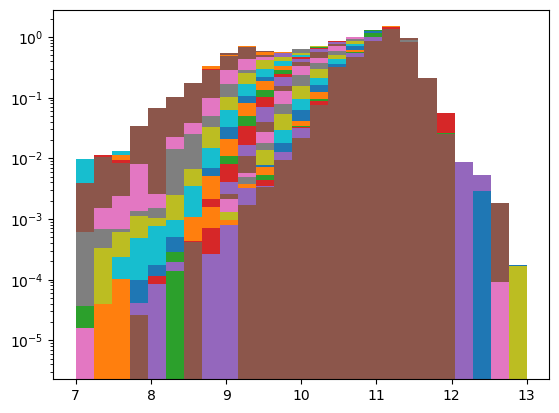

In [17]:
"""
pbar = display.ProgressBar(16)
pbar.display()

for it in range(0, 16):
    testing_centers = table_of_centers_sorted.iloc[70+10*it:70+10*it+5].copy() #Change to 5* later
    ra_dec_list = []
    #Buffer (in degrees, from interpolating maximum cluster radius at z = 0.05)
    buffer = 0.285

    for index, row in testing_centers.iterrows():
        d_ra_dec = data_importer(row)
        ra_dec_list.append(d_ra_dec)
        
    ra_decs = dask.compute(*ra_dec_list)
    ra_dec = pd.concat(ra_decs)
    cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
    z_array = np.linspace(1e-2, ra_dec.Z_PHOT_MEDIAN.max(), 500)
    sparse_radius = (1+z_array)/(cos.comoving_distance(z_array))
    radius_threshold = interp1d(z_array, sparse_radius, kind = "linear", fill_value = "extrapolate")
    median = stats.binned_statistic(ra_dec.Z_PHOT_MEDIAN, ra_dec.Z_PHOT_STD, "median", bins = np.linspace(0.05, ra_dec.Z_PHOT_MEDIAN.max(), 100))
    bins = np.linspace(0.05, ra_dec.Z_PHOT_MEDIAN.max(), 99)
    z_threshold = interp1d(bins, median[0], kind = "linear", fill_value = "extrapolate")
    massive_sample = ra_dec[ra_dec.mass > 11.2].copy()
    massive_sample["neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["ultra_local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["corrected_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["corrected_local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["corrected_ultra_local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["neighbors"] = np.zeros(len(massive_sample))
    massive_sample["local_neighbors"] = np.zeros(len(massive_sample))
    massive_sample["ultra_local_neighbors"] = np.zeros(len(massive_sample))
    massive_sample["neighbor_gids"] = np.zeros(len(massive_sample))
    massive_sample["local_neighbor_gids"] = np.zeros(len(massive_sample))
    massive_sample["ultra_local_neighbor_gids"] = np.zeros(len(massive_sample))
    massive_sample["mass_array"] = np.empty(len(massive_sample), dtype = "object")
    massive_sample["weight_array"] = np.empty(len(massive_sample), dtype = "object")
    massive_sample["fluxg_array"] = np.empty(len(massive_sample), dtype = "object")
    massive_sample["fluxz_array"] = np.empty(len(massive_sample), dtype = "object")
    massive_sample["z_array"] = np.empty(len(massive_sample), dtype = "object")
    massive_sample.reset_index(inplace=True, drop = True)
    tree = spatial.cKDTree(ra_dec[["x", "y"]], copy_data = True)
    
    indexable = ra_dec[["Z_PHOT_MEDIAN", "x", "y", "mass", "gauss_z", "FLUX_G", "FLUX_Z"]].values.copy()
    
    iterrator = massive_sample.copy()
    for i, row in iterrator.iterrows():
        neighbors = tree.query_ball_point([row.x, row.y], radius_threshold(row.Z_PHOT_MEDIAN))
        if len(neighbors) > 0:
            local_data = indexable[neighbors]

            z_c = z_threshold(row.Z_PHOT_MEDIAN)
            cylinder = np.abs(np.vstack(local_data[:, 4]) - row.Z_PHOT_MEDIAN)
            weight_array = cylinder < 2*z_c
            weights = weight_array.sum(axis = 1)/oversample

            approx_cluster = np.append(local_data, np.reshape(weights, newshape = (len(weights), 1)), axis = 1)
            cluster = approx_cluster[approx_cluster[:, -1] > 0]

            r_smaller = radius_threshold(row.Z_PHOT_MEDIAN)
            small_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - row.x)**2 + (cluster[:, 2] - row.y)**2).astype(float)) < 0.5*r_smaller]
            mini_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - row.x)**2 + (cluster[:, 2] - row.y)**2).astype(float)) < 0.1*r_smaller]

            massive_sample.at[i, "neighbors"] = np.sum(cluster[:, -1])
            massive_sample.at[i, "local_neighbors"] = np.sum(small_cluster[:, -1])
            massive_sample.at[i, "ultra_local_neighbors"] = np.sum(mini_cluster[:, -1])

            massive_sample.at[i, "neighbor_mass"] = np.log10(np.sum(np.append((10**cluster[:, 3])*cluster[:, -1], [10**row.mass])))
            c_mask = cluster[:, 3]>mass_limit(row.Z_PHOT_MEDIAN)
            cluster_limited = cluster[c_mask.astype("bool"), :]
            massive_sample.at[i, "corrected_neighbor_mass"] = np.log10(np.sum(np.append(((10**cluster_limited[:, 3]))*cluster_limited[:, -1], [10**row.mass]))*mass_coefficient(row.Z_PHOT_MEDIAN))
            massive_sample.at[i, "local_neighbor_mass"] = np.log10(np.sum(np.append((10**small_cluster[:, 3])*small_cluster[:, -1], [10**row.mass])))
            massive_sample.at[i, "ultra_local_neighbor_mass"] = np.log10(np.sum(np.append((10**mini_cluster[:, 3])*mini_cluster[:, -1], [10**row.mass])))

            massive_sample.at[i, "mass_array"] = np.log10(np.append((10**cluster[:, 3]), [10**row.mass]).astype(float))
            massive_sample.at[i, "weight_array"] = np.append(cluster[:, -1], [1])
            massive_sample.at[i, "fluxg_array"] = np.append(cluster[:, 5], [row.FLUX_G])
            massive_sample.at[i, "fluxz_array"] = np.append(cluster[:, 6], [row.FLUX_Z])
            massive_sample.at[i, "z_array"] = np.append(cluster[:, 0], [row.Z_PHOT_MEDIAN])
    
    bins = np.arange(0.05, massive_sample.Z_PHOT_MEDIAN.max(), 0.01)
    binned = [massive_sample[np.logical_and(massive_sample.Z_PHOT_MEDIAN>=i-.025, massive_sample.Z_PHOT_MEDIAN<=i+.025)].copy() for i in bins]
    clusters = pd.DataFrame()
    threshold1 = np.empty(len(binned))
    threshold2 = np.empty(len(binned))
    for i in range(len(binned)):
        threshold1[i] = np.mean(binned[i].neighbors) + 1.8*np.sqrt(np.mean(binned[i].neighbors))
        threshold2[i] = np.mean(binned[i].local_neighbors) + 1.2*np.sqrt(np.mean(binned[i].local_neighbors))
        
    thresh1 = interp1d(bins, threshold1, kind = "linear", fill_value = "extrapolate")
    thresh2 = interp1d(bins, threshold2, kind = "linear", fill_value = "extrapolate")
    
    clusters = massive_sample[np.logical_and(massive_sample.neighbors >= thresh1(massive_sample.Z_PHOT_MEDIAN), massive_sample.local_neighbors >= thresh2(massive_sample.Z_PHOT_MEDIAN))].copy()
    clusters.sort_values("local_neighbor_mass", inplace = True, ascending = False)
    clusters.reset_index(inplace= True, drop = True)
    
    tree = spatial.cKDTree(clusters[["x", "y"]], copy_data = True)
    clusters["ncluster"] = np.zeros(len(clusters))
    clusternum = 1

    iterrator = clusters.copy()
    for i, row in iterrator.iterrows():
        if clusters.iloc[i].ncluster == 0:
            clusters.at[i, "ncluster"] = clusternum
            neighbors = tree.query_ball_point([row.x, row.y], 1.5*radius_threshold(row.Z_PHOT_MEDIAN))
            for index in neighbors:
                if clusters.at[index, "ncluster"] == 0 and np.abs(clusters.at[index, "Z_PHOT_MEDIAN"] - row.Z_PHOT_MEDIAN) < 2*z_threshold(row.Z_PHOT_MEDIAN):
                    clusters.at[index, "ncluster"] = clusternum

            clusternum += 1
    cluster_center = clusters.sort_values(by = ['ncluster','ultra_local_neighbor_mass'], ascending = [True, False]).groupby('ncluster').head(1).copy()
    bins_z = np.linspace(0.025, 1.025, 22)
    binned = [cluster_center[np.logical_and(cluster_center.Z_PHOT_MEDIAN>=i-.025, cluster_center.Z_PHOT_MEDIAN<=i+0.025)].mass_array.copy() for i in bins_z]
    binned2 = [cluster_center[np.logical_and(cluster_center.Z_PHOT_MEDIAN>=i-.025, cluster_center.Z_PHOT_MEDIAN<=i+0.025)].weight_array.copy() for i in bins_z]
    
    mass_list = []
    for clusters in binned:
        if len(clusters) > 0:
            mass_list += [np.concatenate(clusters.values.flatten())]
        else:
            mass_list += []

    weight_list = []
    for clusters in binned2:
        if len(clusters) > 0:
            weight_list += [np.concatenate(clusters.values.flatten()).astype(float)]
        else:
            weight_list += []
    
    peak_list = np.zeros(22)
    
    for i in range(0, 21):
        n, bins, _ = plt.hist(mass_list[i], weights = weight_list[i], bins= np.linspace(7, 13, 26), log = True, density = True)
        peaks = np.array([n, (bins[1:] + bins[:-1])/2])
        #plt.plot(peaks[1], peaks[0], "o")
        peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
        m_list = np.linspace(6, 13, 100)
        m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
        peak_list[i] = m_peak.x
        #plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
        #plt.show()
    
    #mass_lim = interp1d(bins_z[1:], peak_list[0:-1], kind = "linear", fill_value = "extrapolate")
    #z_test = np.linspace(bins_z[1], bins_z[-1], 100)
    #a, b = np.polyfit(z_test[11:], mass_lim(z_test[11:]), deg = 1)
    #a_s.append(a)
    #bs.append(b)
    #print(a_s, bs)
    a = 1.3620186928378857  
    b = 9.968545069745126
    
    def mass_limit(z):
        return np.minimum((a*z + b), 11.2)
    
    phi_mstar = np.empty(22, dtype = "object")
    
    for i in range(0, 10):
        n, bins, _ = plt.hist(mass_list[i], weights = weight_list[i], bins= np.linspace(7, 13, 26), log = True, density = True)
        peaks = np.array([n, (bins[1:] + bins[:-1])/2])
        threshold = len(peaks[1][peaks[1] > mass_limit(bins_z[i+1])])
        #plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")
        popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), sigma = np.maximum(0.1*peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.min(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))])), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
        m = np.linspace(9.5, 12.5, 100)
        #plt.semilogy(m, schechter_fit_1(10**m, *popt), "-")
        #plt.show()
        phi_mstar[i] = popt
    for i in range(10, 17):
        n, bins, _ = plt.hist(mass_list[i], weights = weight_list[i], bins= np.linspace(7, 13, 26), log = True, density = True)
        peaks = np.array([n, (bins[1:] + bins[:-1])/2])
        threshold = len(peaks[1][peaks[1] > mass_limit(bins_z[i+1])])
        #plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")
        popt, pcov = curve_fit(schechter_fit_2, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], \
                               np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), \
                               sigma = np.maximum(0.1*peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.min(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))])), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
        m = np.linspace(9.5, 12.5, 100)
        #plt.semilogy(m, schechter_fit_2(10**m, *popt), "-")
        #plt.show()
        phi_mstar[i] = popt
    for i in range(17, 21):
        n, bins, _ = plt.hist(mass_list[i], weights = weight_list[i], bins= np.linspace(7, 13, 26), log = True, density = True)
        peaks = np.array([n, (bins[1:] + bins[:-1])/2])
        threshold = len(peaks[1][peaks[1] > mass_limit(bins_z[i+1])])
        #plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")
        popt, pcov = curve_fit(schechter_fit_3, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), sigma = np.maximum(0.1*peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.min(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))])), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
        m = np.linspace(9.5, 12.5, 100)
        #plt.semilogy(m, schechter_fit_3(10**m, *popt), "-")
        #plt.show()
        phi_mstar[i] = popt
    
    PhiMstar = 10**np.stack(phi_mstar[:-1], axis = 1)
    
    m0 = 10
    total_mass = np.zeros(21)
    high_mass = np.zeros(21)
    for i in range(0, 10):
        alpha = -4.58821575e-01
        total_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][i])
        high_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(mass_limit(bins_z[i+1]))/PhiMstar[1][i])
    for i in range(10, 17):
        alpha = -2.23512236e-01
        total_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][i])
        high_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(mass_limit(bins_z[i+1]))/PhiMstar[1][i])
    for i in range(17, 21):
        alpha = -0.07
        total_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][i])
        high_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(mass_limit(bins_z[i+1]))/PhiMstar[1][i])
        
    
    mass_coeff = total_mass/high_mass
    plt.plot(bins_z[1:], mass_coeff, "-r")
    popt, pcov = curve_fit(quadratic, bins_z[1:-3], np.log10(mass_coeff[:-3]), p0 = (1, 1, 0))
    plt.plot(bins_z[1:], 10**quadratic(bins_z[1:], *popt))
    js.append(popt[0])
    ks.append(popt[1])
    ls.append(popt[2])
    
    #print(js, ks, ls)
    #print(it)
    
    pbar.progress = it"""

In [32]:
testing_centers

,index,Unnamed: 0,Unnamed: 0.1,patch,mean_RA,mean_DEC,photoz,masses


In [28]:
it

8

In [ ]:
a = 1.3620186928378857  
b = 9.968545069745126

In [79]:
js

[0.19357798810207832,
 0.19354767469228779,
 0.19326573507641892,
 0.19346830242386456,
 0.19350083962912804,
 0.19344638102658504,
 0.19343978449358862,
 0.19358082566255175,
 0.19361407451886412,
 0.1933670357081001,
 0.1934044813173768,
 0.19355060867090274,
 0.19353077774866484,
 0.19349098570001833,
 0.1934852424401363,
 0.1935637767302031]

In [80]:
ks

[0.23382159719613094,
 0.233868297595681,
 0.2340892842634665,
 0.2339245938220808,
 0.23390263392865904,
 0.23391177251987721,
 0.233965426041287,
 0.23382411286998922,
 0.233793157563674,
 0.23399746019644582,
 0.23393643947187975,
 0.23385238894845808,
 0.23385066327176013,
 0.233915704411126,
 0.2338864740388902,
 0.23381762471869158]

In [82]:
ls

[0.006958943588022022,
 0.00694926274857755,
 0.0069211991011780905,
 0.006943961004966217,
 0.0069492552029799945,
 0.006945555941184976,
 0.006939499103247837,
 0.006958499284871327,
 0.006960994299244094,
 0.006932395878395918,
 0.006942815112658893,
 0.00695297329935636,
 0.006955506493342274,
 0.006942977454925035,
 0.00694940794429306,
 0.006959764616499832]

In [90]:
def mass_coefficient(j, k, l, z):
    return 10**((j)*z**2 + k*z + l)

In [22]:
j_avg, k_avg, l_avg = (np.mean(js), np.mean(ks), np.mean(ls))

In [23]:
print(j_avg, k_avg, l_avg)

0.09466142071765712 0.18101507687467028 -0.005185293498343155


In [85]:
js

[0.19357798810207832,
 0.19354767469228779,
 0.19326573507641892,
 0.19346830242386456,
 0.19350083962912804,
 0.19344638102658504,
 0.19343978449358862,
 0.19358082566255175,
 0.19361407451886412,
 0.1933670357081001,
 0.1934044813173768,
 0.19355060867090274,
 0.19353077774866484,
 0.19349098570001833,
 0.1934852424401363,
 0.1935637767302031,
 0.1934730755413237,
 0.19343447082430804,
 0.19344846394383675,
 0.19345501766889098,
 0.19346277522205513,
 0.19342464660204042,
 0.19341062638552814,
 0.19344551986539094,
 0.19344174734768146,
 0.1934609241256615,
 0.1933594711641795]

In [86]:
ks

[0.23382159719613094,
 0.233868297595681,
 0.2340892842634665,
 0.2339245938220808,
 0.23390263392865904,
 0.23391177251987721,
 0.233965426041287,
 0.23382411286998922,
 0.233793157563674,
 0.23399746019644582,
 0.23393643947187975,
 0.23385238894845808,
 0.23385066327176013,
 0.233915704411126,
 0.2338864740388902,
 0.23381762471869158,
 0.2339021225924415,
 0.23397353804695076,
 0.23392808621399788,
 0.23395245343207519,
 0.23394473096424648,
 0.23398738210852782,
 0.2339999296080248,
 0.2339645805509769,
 0.23396977123749374,
 0.23393514105629012,
 0.2340055308818063]

In [87]:
ls

[0.006958943588022022,
 0.00694926274857755,
 0.0069211991011780905,
 0.006943961004966217,
 0.0069492552029799945,
 0.006945555941184976,
 0.006939499103247837,
 0.006958499284871327,
 0.006960994299244094,
 0.006932395878395918,
 0.006942815112658893,
 0.00695297329935636,
 0.006955506493342274,
 0.006942977454925035,
 0.00694940794429306,
 0.006959764616499832,
 0.006946104483710809,
 0.00693840200707473,
 0.006942793328995316,
 0.006940275895586232,
 0.0069415055305688134,
 0.006933838337038908,
 0.006932966301193176,
 0.006936897637389609,
 0.006937390821561152,
 0.006939727426896231,
 0.006931541622031537]

In [88]:
j_avg, k_avg, l_avg = (np.mean(js), np.mean(ks), np.mean(ls))
print(j_avg, k_avg, l_avg)

0.1934685649122839 0.23392299620558993 0.0069438686839181476


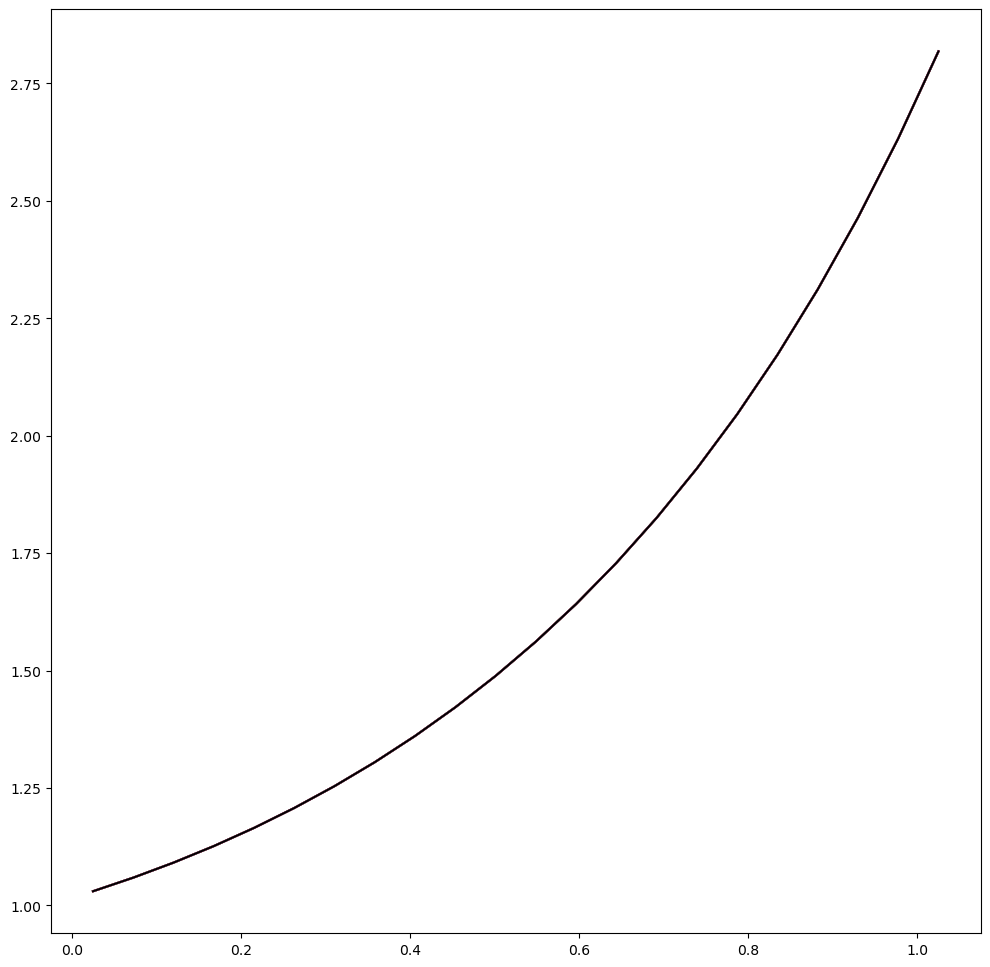

In [91]:
plt.figure(figsize = (12, 12))
z = np.linspace(0.025, 1.025, 22)
for i in range(7):
    plt.plot(z, mass_coefficient(js[i], ks[i], ls[i], z))
plt.plot(z, mass_coefficient(j_avg, k_avg, l_avg, z), "-k")
plt.show()

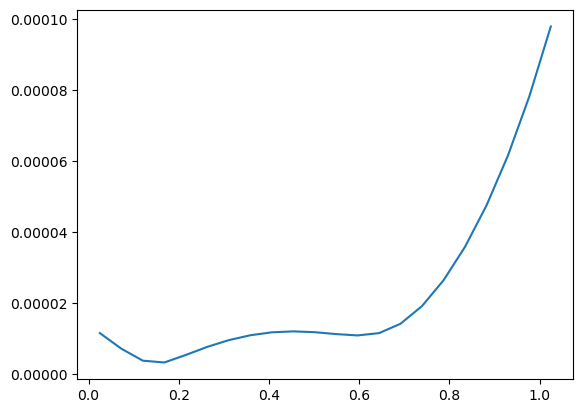

In [58]:
z2 = z.reshape((1, 22))
std_mass_coeff = np.std(10**(np.array(js).reshape((8, 1))*z**2 + np.array(ks).reshape((8, 1))*z + np.array(ls).reshape((8, 1))), axis = 0)
z = np.linspace(0.025, 1.025, 22)
plt.plot(z, std_mass_coeff)
plt.show()

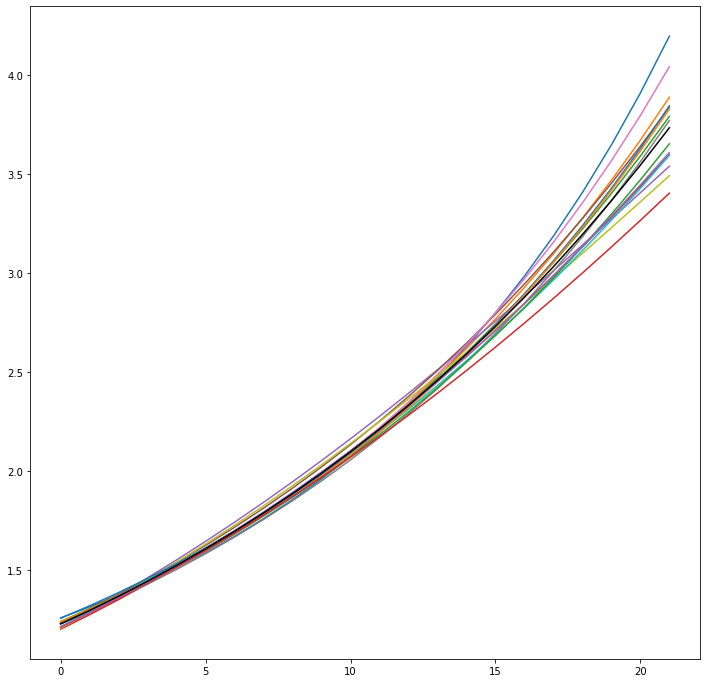

In [58]:
plt.figure(figsize = (12, 12))
z = np.linspace(0.025, 1.025, 22)
for i in range(15):
    plt.plot(mass_coefficient(js[i], ks[i], ls[i], z))
plt.plot(mass_coefficient(j_avg, k_avg, l_avg, z), "-k")
plt.show()

In [44]:
j_avg, k_avg, l_avg = (np.mean(js), np.mean(ks), np.mean(ls))

In [59]:
print(j_avg, k_avg, l_avg)

-0.010062146327355921 0.4931848214696567 0.07716204385814744


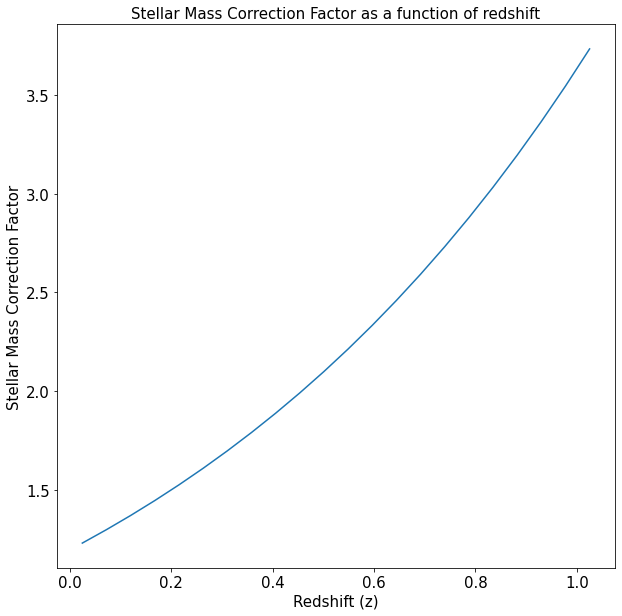

In [5]:
j_avg, k_avg, l_avg = -0.010062146327355921, 0.4931848214696567, 0.07716204385814744,
z = np.linspace(0.025, 1.025, 22)
plt.figure(figsize = (10, 10))
plt.plot(z, mass_coefficient(j_avg, k_avg, l_avg, z))
plt.xlabel("Redshift (z)",  fontsize = 15)
plt.ylabel("Stellar Mass Correction Factor",  fontsize = 15)
plt.title("Stellar Mass Correction Factor as a function of redshift", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [56]:
z2 = z.reshape((1, 22))
std_mass_coeff = np.std(10**(np.array(js).reshape((15, 1))*z**2 + np.array(ks).reshape((15, 1))*z + np.array(ls).reshape((15, 1))), axis = 0)

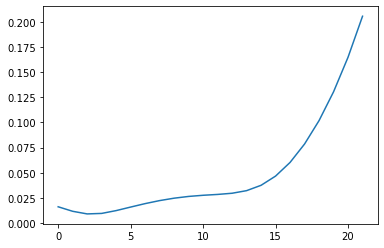

In [57]:
z = np.linspace(0.025, 1.025, 22)
plt.plot(std_mass_coeff)
plt.show()